In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
pip install watermark -q

In [ ]:
%reload_ext watermark
%watermark -iv -a 'Max Magid' -u -d -v

Author: Max Magid

Last updated: 2022-08-20

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

sklearn   : 1.0.2
google    : 2.0.3
numpy     : 1.21.6
matplotlib: 3.2.2
pandas    : 1.3.5



## Import Datasets

##### 2019 Data

In [ ]:
bband19=pd.read_csv('processed data/bband_2019.csv').iloc[:,1:]

In [ ]:
ibn=pd.read_csv('raw data/IBNTracts.csv')

In [ ]:
fcc19=pd.read_csv('raw data/FCC 477/tract_map_jun_2019/tract_map_jun_2019.csv')

#### 2018 Data

In [ ]:
bband18=pd.read_csv('processed data/bband_2018.csv').iloc[:,1:]

In [ ]:
nanda_14_18=pd.read_csv('raw data/nanda_broadband_tract_2014-2018_01P.csv')

In [ ]:
nanda_18=nanda_14_18.loc[nanda_14_18.year==2018]

In [ ]:
fcc18=pd.read_csv('raw data/FCC 477/tract_map_dec_2018.csv')

#### 2017 Data

In [ ]:
bband17=pd.read_csv('processed data/bband_2017.csv').iloc[:,1:]

In [ ]:
fcc17=pd.read_csv('raw data/FCC 477/tract_map_dec_2017.csv')

In [ ]:
nanda_17=nanda_14_18.loc[nanda_14_18.year==2017]

#### 2016 Data

In [ ]:
fcc16=pd.read_csv('raw data/FCC 477/tract_map_dec_2016.csv')

In [ ]:
nanda_16=nanda_14_18.loc[nanda_14_18.year==2016]

#### 2015 Data

In [ ]:
fcc15=pd.read_csv('raw data/FCC 477/tract_map_dec_2015.csv')

In [ ]:
nanda_15=nanda_14_18.loc[nanda_14_18.year==2015]

#### 2014 Data

In [ ]:
fcc14=pd.read_csv('raw data/FCC 477/tract_map_dec_2014.csv')

In [ ]:
nanda_14=nanda_14_18.loc[nanda_14_18.year==2014]

#### 2013 Data

In [ ]:
fcc13=pd.read_csv('raw data/FCC 477/hs_tractdata_v1_dec_2013.csv',encoding='cp1252')

#### 2012 Data

In [ ]:
fcc12=pd.read_csv('raw data/FCC 477/hs_tractdata_v2_dec_2012.csv',encoding='cp1252')

#### 2011 Data

In [ ]:
fcc11=pd.read_csv('raw data/FCC 477/hs_tractdata_v2_dec_2011.csv',encoding='cp1252')

## Creating a Weighted Longitudinal Score

In [ ]:
#Multiplier based on confidence and changing definitions of high-speed internet
fcc_pre15=6/4
nanda_weight=2
#Weights
current=3/4
lag=1/4

#### Creating Pre-2014 Scores

In [ ]:
fcc11.head(2)

,tract_fips,state,county,tract,statename,countyname,tractname,rfc_per_1000_hhs,rfc_per_1000_hhs_nbp,total_prov,total_residential_prov,total_residential_prov_nbp,tmw_prov
0,1001020100,1,1,20100,Alabama,Autauga County,Census Tract 201,4,3,5,4,1,1
1,1001020200,1,1,20200,Alabama,Autauga County,Census Tract 202,3,3,6,4,1,4


In [ ]:
# calculate baseline score out of 10, using weighting from before the change in high-speed definition
fcc11['score11']=fcc_pre15*fcc11.rfc_per_1000_hhs_nbp

In [ ]:
# start a dataframe with just relevant information
df=fcc11[['tract_fips', 'state', 'county', 'tract', 'statename', 'countyname','score11']]

In [ ]:
# Merge in the score from 2012, using the same weighting as before. Include the lag as a component to smooth 
# the jump from one year to the next
df=df.merge(fcc12[['rfc_per_1000_hhs_btop','tract_fips']],left_on='tract_fips',right_on='tract_fips')
df['score12']=current*(fcc_pre15*df.rfc_per_1000_hhs_btop)+lag*(df.score11)
df=df.drop(columns='rfc_per_1000_hhs_btop')

In [ ]:
# Merge in the score from 2013, using the same weighting as before
df=df.merge(fcc13[['rfc_per_1000_hhs_nbp','tract_fips']],left_on='tract_fips',right_on='tract_fips')
df['score13']=current*(fcc_pre15*df.rfc_per_1000_hhs_nbp)+lag*(df.score12)
df=df.drop(columns='rfc_per_1000_hhs_nbp')

#### 2014 Score

In [ ]:
# format nanda scores to fit with format of fcc scores
n_score=[]
for i in range(len(nanda_14)):
  if nanda_14.iloc[i].rfhsc_per_1000_hhs_10_1=='Zero':
    n_score.append(0)
  elif nanda_14.iloc[i].rfhsc_per_1000_hhs_10_1=='Zero < x <= 200':
    n_score.append(1)
  elif nanda_14.iloc[i].rfhsc_per_1000_hhs_10_1=='200 < x <= 400':
    n_score.append(2)
  elif nanda_14.iloc[i].rfhsc_per_1000_hhs_10_1=='400 < x <= 600':
    n_score.append(3)
  elif nanda_14.iloc[i].rfhsc_per_1000_hhs_10_1=='600 < x <= 800':
    n_score.append(4)
  elif nanda_14.iloc[i].rfhsc_per_1000_hhs_10_1=='800 < x':
    n_score.append(5)

nanda_14['score']=n_score  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# Merge nanda and fcc scores into same dataframe, filling in null keys
fcc14=fcc14.merge(nanda_14[['tract_fips10','score']],how='outer',left_on='tractcode',right_on='tract_fips10')
fips=[]
for i in range(len(fcc14)):
  if fcc14.iloc[i].isna()[0]:
    fips.append(fcc14.iloc[i].tract_fips10)
  else:
    fips.append(fcc14.iloc[i].tractcode)
fcc14['tractcode']=fips

In [ ]:
# fill in null values with the other scores
sfill=[]
for i in range(len(fcc14)):
  if fcc14.iloc[i].isna()[4]:
    sfill.append(fcc14.iloc[i].pcat_3x768)
  else:
    sfill.append(fcc14.iloc[i].score)
fcc14['score']=sfill

pcfill=[]
for i in range(len(fcc14)):
  if fcc14.iloc[i].isna()[2]:
    pcfill.append(fcc14.iloc[i].score)
  else:
    pcfill.append(fcc14.iloc[i].pcat_3x768)
fcc14['pcat_3x768']=pcfill

In [ ]:
fcc14.head()

,tractcode,pcat_all,pcat_3x768,tract_fips10,score
0,1.001020e+09,4.0,4.0,1.001020e+09,4.0
1,1.001020e+09,3.0,3.0,1.001020e+09,3.0
2,1.001020e+09,4.0,4.0,1.001020e+09,4.0
3,1.001020e+09,5.0,4.0,1.001020e+09,4.0
4,1.001020e+09,5.0,5.0,1.001020e+09,4.0


In [ ]:
# Merge into larger dataframe and sum up the score using appropriate weights

df=df.merge(fcc14[['pcat_3x768','score','tractcode']],left_on='tract_fips',right_on='tractcode')
df['score14']=current*(fcc_pre15*df.pcat_3x768+nanda_weight*df.score)/2+lag*(df.score13)
df=df.drop(columns=['pcat_3x768','score','tractcode'])

#### 2015 Score

In [ ]:
#Same process as 2014
n_score=[]
for i in range(len(nanda_15)):
  if nanda_15.iloc[i].rfhsc_per_1000_hhs_10_1=='Zero':
    n_score.append(0)
  elif nanda_15.iloc[i].rfhsc_per_1000_hhs_10_1=='Zero < x <= 200':
    n_score.append(1)
  elif nanda_15.iloc[i].rfhsc_per_1000_hhs_10_1=='200 < x <= 400':
    n_score.append(2)
  elif nanda_15.iloc[i].rfhsc_per_1000_hhs_10_1=='400 < x <= 600':
    n_score.append(3)
  elif nanda_15.iloc[i].rfhsc_per_1000_hhs_10_1=='600 < x <= 800':
    n_score.append(4)
  elif nanda_15.iloc[i].rfhsc_per_1000_hhs_10_1=='800 < x':
    n_score.append(5)

nanda_15['score']=n_score  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
fcc15=fcc15.merge(nanda_15[['tract_fips10','score']],how='outer',left_on='tractcode',right_on='tract_fips10')
fips=[]
for i in range(len(fcc15)):
  if fcc15.iloc[i].isna()[0]:
    fips.append(fcc15.iloc[i].tract_fips10)
  else:
    fips.append(fcc15.iloc[i].tractcode)
fcc15['tractcode']=fips

In [ ]:
sfill=[]
for i in range(len(fcc15)):
  if fcc15.iloc[i].isna()[4]:
    sfill.append(fcc15.iloc[i].pcat_10x1)
  else:
    sfill.append(fcc15.iloc[i].score)
fcc15['score']=sfill

pcfill=[]
for i in range(len(fcc15)):
  if fcc15.iloc[i].isna()[2]:
    pcfill.append(fcc15.iloc[i].score)
  else:
    pcfill.append(fcc15.iloc[i].pcat_10x1)
fcc15['pcat_10x1']=pcfill

In [ ]:
fcc15.head()

,tractcode,pcat_all,pcat_10x1,tract_fips10,score
0,1.001020e+09,4.0,4.0,1.001020e+09,4.0
1,1.001020e+09,4.0,3.0,1.001020e+09,3.0
2,1.001020e+09,5.0,4.0,1.001020e+09,4.0
3,1.001020e+09,5.0,4.0,1.001020e+09,4.0
4,1.001020e+09,5.0,4.0,1.001020e+09,4.0


In [ ]:
# With the change in data definitions, fcc data and nanda data are now weighted the same

df=df.merge(fcc15[['pcat_10x1','score','tractcode']],left_on='tract_fips',right_on='tractcode')
df['score15']=current*(nanda_weight*df.pcat_10x1+nanda_weight*df.score)/2+lag*(df.score14)
df=df.drop(columns=['pcat_10x1','score','tractcode'])

#### 2016 Score

In [ ]:
# Same process as in 2014
n_score=[]
for i in range(len(nanda_16)):
  if nanda_16.iloc[i].rfhsc_per_1000_hhs_10_1=='Zero':
    n_score.append(0)
  elif nanda_16.iloc[i].rfhsc_per_1000_hhs_10_1=='Zero < x <= 200':
    n_score.append(1)
  elif nanda_16.iloc[i].rfhsc_per_1000_hhs_10_1=='200 < x <= 400':
    n_score.append(2)
  elif nanda_16.iloc[i].rfhsc_per_1000_hhs_10_1=='400 < x <= 600':
    n_score.append(3)
  elif nanda_16.iloc[i].rfhsc_per_1000_hhs_10_1=='600 < x <= 800':
    n_score.append(4)
  elif nanda_16.iloc[i].rfhsc_per_1000_hhs_10_1=='800 < x':
    n_score.append(5)

nanda_16['score']=n_score  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
fcc16=fcc16.merge(nanda_16[['tract_fips10','score']],how='outer',left_on='tractcode',right_on='tract_fips10')
fips=[]
for i in range(len(fcc16)):
  if fcc16.iloc[i].isna()[0]:
    fips.append(fcc16.iloc[i].tract_fips10)
  else:
    fips.append(fcc16.iloc[i].tractcode)
fcc16['tractcode']=fips

In [ ]:
sfill=[]
for i in range(len(fcc16)):
  if fcc16.iloc[i].isna()[4]:
    sfill.append(fcc16.iloc[i].pcat_10x1)
  else:
    sfill.append(fcc16.iloc[i].score)
fcc16['score']=sfill

pcfill=[]
for i in range(len(fcc16)):
  if fcc16.iloc[i].isna()[2]:
    pcfill.append(fcc16.iloc[i].score)
  else:
    pcfill.append(fcc16.iloc[i].pcat_10x1)
fcc16['pcat_10x1']=pcfill

In [ ]:
fcc16.head()

,tractcode,pcat_all,pcat_10x1,tract_fips10,score
0,1.001020e+09,4.0,4.0,1.001020e+09,4.0
1,1.001020e+09,4.0,4.0,1.001020e+09,4.0
2,1.001020e+09,5.0,4.0,1.001020e+09,4.0
3,1.001020e+09,5.0,5.0,1.001020e+09,5.0
4,1.001020e+09,5.0,5.0,1.001020e+09,5.0


In [ ]:
# Same weighting as 2015
df=df.merge(fcc16[['pcat_10x1','score','tractcode']],left_on='tract_fips',right_on='tractcode')
df['score16']=current*(nanda_weight*df.pcat_10x1+nanda_weight*df.score)/2+lag*(df.score15)
df=df.drop(columns=['pcat_10x1','score','tractcode'])

#### 2017 Score

In [ ]:
# Same process to prepare nanda score
n_score=[]
for i in range(len(nanda_17)):
  if nanda_17.iloc[i].rfhsc_per_1000_hhs_10_1=='Zero':
    n_score.append(0)
  elif nanda_17.iloc[i].rfhsc_per_1000_hhs_10_1=='Zero < x <= 200':
    n_score.append(1)
  elif nanda_17.iloc[i].rfhsc_per_1000_hhs_10_1=='200 < x <= 400':
    n_score.append(2)
  elif nanda_17.iloc[i].rfhsc_per_1000_hhs_10_1=='400 < x <= 600':
    n_score.append(3)
  elif nanda_17.iloc[i].rfhsc_per_1000_hhs_10_1=='600 < x <= 800':
    n_score.append(4)
  elif nanda_17.iloc[i].rfhsc_per_1000_hhs_10_1=='800 < x':
    n_score.append(5)

nanda_17['score']=n_score  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
fcc17=fcc17.merge(nanda_17[['tract_fips10','score']],how='outer',left_on='tractcode',right_on='tract_fips10')
fips=[]
for i in range(len(fcc17)):
  if fcc17.iloc[i].isna()[0]:
    fips.append(fcc17.iloc[i].tract_fips10)
  else:
    fips.append(fcc17.iloc[i].tractcode)
fcc17['tractcode']=fips

In [ ]:
sfill=[]
for i in range(len(fcc17)):
  if fcc17.iloc[i].isna()[4]:
    sfill.append(fcc17.iloc[i].pcat_10x1)
  else:
    sfill.append(fcc17.iloc[i].score)
fcc17['score']=sfill

pcfill=[]
for i in range(len(fcc17)):
  if fcc17.iloc[i].isna()[2]:
    pcfill.append(fcc17.iloc[i].score)
  else:
    pcfill.append(fcc17.iloc[i].pcat_10x1)
fcc17['pcat_10x1']=pcfill

In [ ]:
fcc17.head()

,tractcode,pcat_all,pcat_10x1,tract_fips10,score
0,1.001020e+09,5.0,4.0,1.001020e+09,4.0
1,1.001020e+09,4.0,4.0,1.001020e+09,4.0
2,1.001020e+09,5.0,4.0,1.001020e+09,4.0
3,1.001020e+09,5.0,4.0,1.001020e+09,4.0
4,1.001020e+09,5.0,5.0,1.001020e+09,5.0


In [ ]:
# Create a matching key for bband data to eventually merge to the larger dataset
key=[]
for i in range(len(bband17)):
  key.append(int(bband17.iloc[i].GEOID[7:]))
bband17['key']=key

In [ ]:
# find how many houses have broadband out of 10
bband17['bband_score']=bband17.has_broadband/bband17.households*10

In [ ]:
# Create the same ranking system as used with nanda and fcc
b_score=[]
for i in range(len(bband17)):
  if bband17.iloc[i].bband_score==0:
    b_score.append(0)
  elif bband17.iloc[i].bband_score<= 2:
    b_score.append(1)
  elif bband17.iloc[i].bband_score<= 4:
    b_score.append(2)
  elif bband17.iloc[i].bband_score<= 6:
    b_score.append(3)
  elif bband17.iloc[i].bband_score<= 8:
    b_score.append(4)
  elif bband17.iloc[i].bband_score>8:
    b_score.append(5)
  else:
    b_score.append(0)

bband17['bband_score']=b_score  

In [ ]:
# merge them all together, all of them have the same weighting, except for the lag
df=df.merge(fcc17[['pcat_10x1','score','tractcode']],left_on='tract_fips',right_on='tractcode')
df=df.merge(bband17[['key','bband_score']],left_on='tract_fips',right_on='key')
df['score17']=current*(nanda_weight*df.pcat_10x1+nanda_weight*df.score+nanda_weight*df.bband_score)/3+lag*(df.score16)
df=df.drop(columns=['pcat_10x1','score','tractcode','key','bband_score'])

#### 2018 Score

In [ ]:
# 2018 score calculated same as 2017
n_score=[]
for i in range(len(nanda_18)):
  if nanda_18.iloc[i].rfhsc_per_1000_hhs_10_1=='Zero':
    n_score.append(0)
  elif nanda_18.iloc[i].rfhsc_per_1000_hhs_10_1=='Zero < x <= 200':
    n_score.append(1)
  elif nanda_18.iloc[i].rfhsc_per_1000_hhs_10_1=='200 < x <= 400':
    n_score.append(2)
  elif nanda_18.iloc[i].rfhsc_per_1000_hhs_10_1=='400 < x <= 600':
    n_score.append(3)
  elif nanda_18.iloc[i].rfhsc_per_1000_hhs_10_1=='600 < x <= 800':
    n_score.append(4)
  elif nanda_18.iloc[i].rfhsc_per_1000_hhs_10_1=='800 < x':
    n_score.append(5)

nanda_18['score']=n_score  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
fcc18=fcc18.merge(nanda_18[['tract_fips10','score']],how='outer',left_on='tractcode',right_on='tract_fips10')
fips=[]
for i in range(len(fcc18)):
  if fcc18.iloc[i].isna()[0]:
    fips.append(fcc18.iloc[i].tract_fips10)
  else:
    fips.append(fcc18.iloc[i].tractcode)
fcc18['tractcode']=fips

In [ ]:
sfill=[]
for i in range(len(fcc18)):
  if fcc18.iloc[i].isna()[4]:
    sfill.append(fcc18.iloc[i].pcat_10x1)
  else:
    sfill.append(fcc18.iloc[i].score)
fcc18['score']=sfill

pcfill=[]
for i in range(len(fcc18)):
  if fcc18.iloc[i].isna()[2]:
    pcfill.append(fcc18.iloc[i].score)
  else:
    pcfill.append(fcc18.iloc[i].pcat_10x1)
fcc18['pcat_10x1']=pcfill

In [ ]:
fcc18.head()

,tractcode,pcat_all,pcat_10x1,tract_fips10,score
0,1.001020e+09,4.0,4.0,1.001020e+09,4.0
1,1.001020e+09,4.0,4.0,1.001020e+09,4.0
2,1.001020e+09,4.0,4.0,1.001020e+09,4.0
3,1.001020e+09,5.0,5.0,1.001020e+09,4.0
4,1.001020e+09,5.0,5.0,1.001020e+09,5.0


In [ ]:
key=[]
for i in range(len(bband18)):
  key.append(int(bband18.iloc[i].GEOID[7:]))
bband18['key']=key

In [ ]:
bband18['bband_score']=bband18.has_broadband/bband18.households*10

In [ ]:
b_score=[]
for i in range(len(bband18)):
  if bband18.iloc[i].bband_score==0:
    b_score.append(0)
  elif bband18.iloc[i].bband_score<= 2:
    b_score.append(1)
  elif bband18.iloc[i].bband_score<= 4:
    b_score.append(2)
  elif bband18.iloc[i].bband_score<= 6:
    b_score.append(3)
  elif bband18.iloc[i].bband_score<= 8:
    b_score.append(4)
  elif bband18.iloc[i].bband_score>8:
    b_score.append(5)
  else:
    b_score.append(0)

bband18['bband_score']=b_score  

In [ ]:
df=df.merge(fcc18[['pcat_10x1','score','tractcode']],left_on='tract_fips',right_on='tractcode')
df=df.merge(bband18[['key','bband_score']],left_on='tract_fips',right_on='key')
df['score18']=current*(nanda_weight*df.pcat_10x1+nanda_weight*df.score+nanda_weight*df.bband_score)/3+lag*(df.score17)
df=df.drop(columns=['pcat_10x1','score','tractcode','key','bband_score'])

#### 2019 Score

In [ ]:
fcc19.head()

,tractcode,pcat_all,pcat_10x1
0,1001020100,4,4
1,1001020200,5,4
2,1001020300,4,4
3,1001020400,5,5
4,1001020500,5,5


In [ ]:
key=[]
for i in range(len(bband19)):
  key.append(int(bband19.iloc[i].GEOID[7:]))
bband19['key']=key

In [ ]:
bband19['bband_score']=bband19.has_broadband/bband19.households*10

In [ ]:
b_score=[]
for i in range(len(bband19)):
  if bband19.iloc[i].bband_score==0:
    b_score.append(0)
  elif bband19.iloc[i].bband_score<= 200:
    b_score.append(1)
  elif bband19.iloc[i].bband_score<= 400:
    b_score.append(2)
  elif bband19.iloc[i].bband_score<= 600:
    b_score.append(3)
  elif bband19.iloc[i].bband_score<= 800:
    b_score.append(4)
  elif bband19.iloc[i].bband_score>800:
    b_score.append(5)
  else:
    b_score.append(0)

bband19['bband_score']=b_score  

In [ ]:
df=df.merge(fcc19[['pcat_10x1','tractcode']],left_on='tract_fips',right_on='tractcode')
df=df.merge(bband19[['key','bband_score']],left_on='tract_fips',right_on='key')
df['score19']=current*(nanda_weight*df.pcat_10x1+nanda_weight*df.bband_score)/2+lag*(df.score18)
df=df.drop(columns=['pcat_10x1','tractcode','key','bband_score'])

In [ ]:
df.head(2)

,tract_fips,state,county,tract,statename,countyname,score11,score12,score13,score14,score15,score16,score17,score18,score19
0,1001020100,1,1,20100,Alabama,Autauga County,4.5,6.75,7.3125,7.078125,7.769531,7.942383,7.985596,7.996399,5.749100
1,1001020200,1,1,20200,Alabama,Autauga County,4.5,4.50,4.5000,5.062500,5.765625,7.441406,7.860352,7.965088,5.741272


## Create New Dataset for Comparison

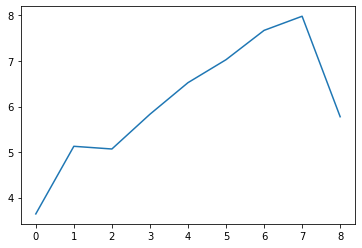

In [ ]:
# Examine what the general trend looks like
means=[df.score11.mean(),df.score12.mean(),df.score13.mean(),df.score14.mean(),
       df.score15.mean(),df.score16.mean(),df.score17.mean(),df.score18.mean(),
       df.score19.mean()]
plt.plot(means)

In [ ]:
#standardize to mitigate effects of discontinuities
df['2011']=(df.score11-df.score11.mean())/df.score11.std()
df['2012']=(df.score12-df.score12.mean())/df.score12.std()
df['2013']=(df.score13-df.score13.mean())/df.score13.std()
df['2014']=(df.score14-df.score14.mean())/df.score14.std()
df['2015']=(df.score15-df.score15.mean())/df.score15.std()
df['2016']=(df.score16-df.score16.mean())/df.score16.std()
df['2017']=(df.score17-df.score17.mean())/df.score17.std()
df['2018']=(df.score18-df.score18.mean())/df.score18.std()
df['2019']=(df.score19-df.score19.mean())/df.score19.std()

In [ ]:
df.columns

Index(['tract_fips', 'state', 'county', 'tract', 'statename', 'countyname',
       'score11', 'score12', 'score13', 'score14', 'score15', 'score16',
       'score17', 'score18', 'score19', '2011', '2012', '2013', '2014', '2015',
       '2016', '2017', '2018', '2019'],
      dtype='object')

In [ ]:
# Keep just standardized scores
df2=df[['tract_fips', 'state', 'county', 'tract', 'statename', 'countyname',
        '2011', '2012', '2013','2014', '2015', '2016', '2017', '2018', '2019']]

In [ ]:
# Make a column for the year of each score, create new column called "normalized score"
df_comp=df2.melt(id_vars=['tract_fips', 'state', 'county', 'tract', 'statename', 'countyname'],
         var_name='year',value_name='normalized_score')

In [ ]:
# Attach a column of the normalized score one year before
df_comp['lag1_diff']=df_comp[['normalized_score']].diff(periods=len(df2), axis=0)

In [ ]:
# Attach a column of the normalized score two year before
df_comp['lag2_diff']=df_comp[['normalized_score']].diff(periods=2*len(df2), axis=0)

In [ ]:
# Attach a column of the normalized score three year before
df_comp['lag3_diff']=df_comp[['normalized_score']].diff(periods=3*len(df2), axis=0)

In [ ]:
df_comp.head(2)

,tract_fips,state,county,tract,statename,countyname,year,normalized_score,lag1_diff,lag2_diff,lag3_diff
0,1001020100,1,1,20100,Alabama,Autauga County,2011,0.452813,NaN,NaN,NaN
1,1001020200,1,1,20200,Alabama,Autauga County,2011,0.452813,NaN,NaN,NaN


In [ ]:
df_comp.to_csv('processed data/bband_score.csv')